In [193]:
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

from spineq.data_fetcher import get_oa_shapes, get_oa_centroids
from spineq.plotting import plot_oa_weights, get_color_axis, plot_optimisation_result
from spineq.greedy import greedy_opt
from spineq.optimise import make_result_dict
from spineq.utils import coverage_matrix

import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

## Space Syntax

In [2]:
p = "/Users/jroberts/Newcastle University/Eman Zied - Spatial Inequality in The Smart City 2021-22/Space Syntax/Newcastle Space Syntax/Newcastle_Analysed.shp"
ss = gpd.read_file(p)
ss

fid      id  SegID       AI_   AI__N      AI__TD     AI__MD  \
0            1.0       1      1  0.040449  104786  2590537.50  24.722408   
1            2.0       2      1  0.040451  104786  2590448.75  24.721561   
2            3.0       3      1  0.040451  104786  2590389.50  24.720995   
3            4.0       4      1  0.040452  104786  2590351.25  24.720630   
4            5.0       5      1  0.040453  104786  2590311.75  24.720253   
...          ...     ...    ...       ...     ...         ...        ...   
104781  104893.0  104893  33329  0.041157  104786  2546010.00  24.297466   
104782  104894.0  104894  33329  0.041848  104786  2503931.75  23.895899   
104783  104895.0  104895  33329  0.041848  104786  2503924.00  23.895825   
104784  104896.0  104896  33329  0.042356  104786  2473887.25  23.609174   
104785  104897.0  104897  33329  0.042680  104786  2455110.25  23.429978   

              AC_  AC__NACH   AC__N      AC__TD     AC__MD  \
0             0.0  0.000000  104786  2590537.50  24.722408   
1        209568.0  0.829723  104786  2590448.75  24.721561   
2        419132.0  0.876662  104786  2590389.50  24.720995   
3        628692.0  0.904119  104786  2590351.25  24.720630   
4        838248.0  0.923600  104786  2590311.75  24.720253   
...           ...       ...     ...         ...        ...   
104781  2096397.0  0.986827  104786  2546010.00  24.297466   
104782  2301617.0  0.994282  104786  2503931.75  23.895899   
104783  2507777.0  1.000104  104786  2503924.00  23.895825   
104784  2713997.0  1.006292  104786  2473887.25  23.609174   
104785  2920361.0  1.011794  104786  2455110.25  23.429978   

                                                 geometry  
0       LINESTRING (425470.640 582992.090, 425485.890 ...  
1       LINESTRING (425485.890 582988.740, 425489.920 ...  
2       LINESTRING (425489.920 582987.860, 425500.000 ...  
3       LINESTRING (425500.000 582985.650, 425513.010 ...  
4       LINESTRING (425513.010 582982.790, 425543.750 ...  
...                                                   ...  
104781  LINESTRING (411692.200 562093.400, 411704.600 ...  
104782  LINESTRING (411704.600 562106.200, 411790.460 ...  
104783  LINESTRING (411790.460 562119.660, 411799.000 ...  
104784  LINESTRING (411799.000 562121.000, 411826.000 ...  
104785  LINESTRING (411826.000 562140.000, 412147.000 ...  

[104786 rows x 13 columns]

Text(0.5, 1.0, 'AC__NACH')

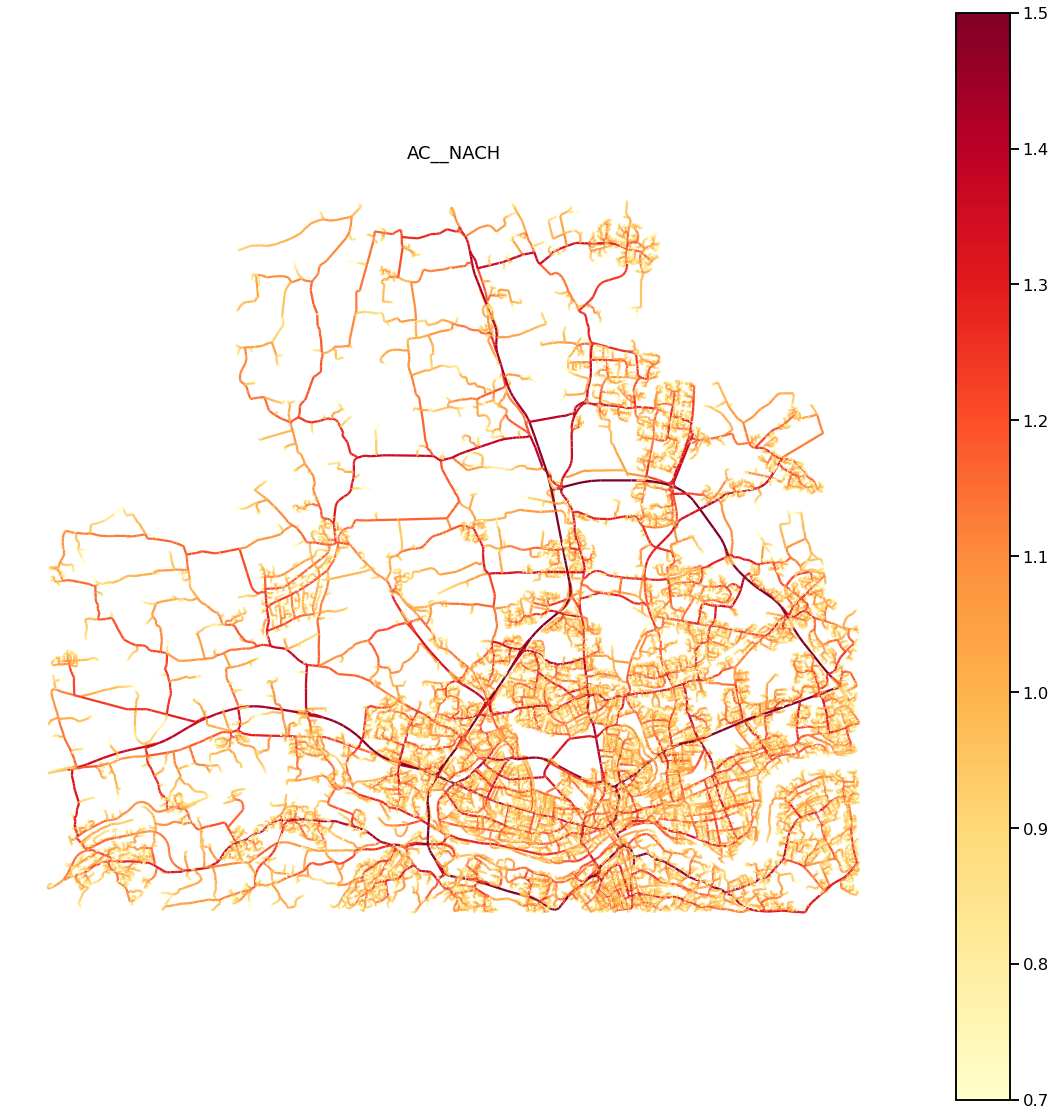

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(column="AC__NACH", ax=ax, cmap="YlOrRd", legend=True, vmin=0.7, vmax=1.5)
ax.axis("off")
ax.set_title("AC__NACH")

<AxesSubplot:ylabel='Frequency'>

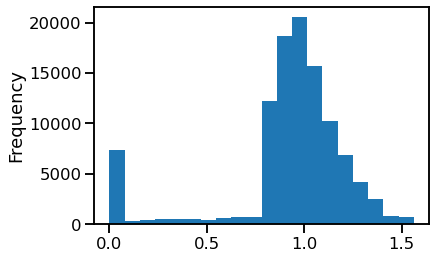

In [4]:
ss["AC__NACH"].plot.hist(bins=20)

## Raw DFT Traffic Data

In [5]:
dft = pd.read_csv("../data/raw/raw_dft_data/dft_aadf_local_authority_id_172.csv")
dft.head()

count_point_id  year  region_id region_name  local_authority_id  \
0           46650  2019         11  North East                 172   
1            6745  2019         11  North East                 172   
2            6740  2019         11  North East                 172   
3           38720  2019         11  North East                 172   
4           37534  2019         11  North East                 172   

  local_authority_name road_name road_type       start_junction_road_name  \
0  Newcastle upon Tyne      A191     Major                      A1(T)/A69   
1  Newcastle upon Tyne      A193     Major                   A193/A167(M)   
2  Newcastle upon Tyne      A191     Major                           A189   
3  Newcastle upon Tyne        A1     Major  Kingston Park Road roundabout   
4  Newcastle upon Tyne      A186     Major                Clayton St West   

  end_junction_road_name  ...  buses_and_coaches   lgvs  hgvs_2_rigid_axle  \
0                  B1311  ...                 93   1063                 77   
1                   A193  ...                 76   2959                157   
2                   A188  ...                174   1843                 80   
3    A1056 North Brunton  ...                140  12151               1075   
4         Collingwood St  ...                777    587                 83   

   hgvs_3_rigid_axle  hgvs_4_or_more_rigid_axle  hgvs_3_or_4_articulated_axle  \
0                  9                         16                             0   
1                 26                         17                             9   
2                  8                          9                             3   
3                236                        450                           119   
4                 12                          5                             7   

  hgvs_5_articulated_axle hgvs_6_articulated_axle  all_hgvs  \
0                       1                       2       104   
1                      20                      12       240   
2                       3                       9       113   
3                     906                     947      3733   
4                       5                       5       116   

   all_motor_vehicles  
0                8358  
1               21292  
2               14107  
3               85837  
4                6864  

[5 rows x 31 columns]

In [6]:
select_year = 2019
dft = dft[dft["year"] == select_year]
dft.head()

count_point_id  year  region_id region_name  local_authority_id  \
0           46650  2019         11  North East                 172   
1            6745  2019         11  North East                 172   
2            6740  2019         11  North East                 172   
3           38720  2019         11  North East                 172   
4           37534  2019         11  North East                 172   

  local_authority_name road_name road_type       start_junction_road_name  \
0  Newcastle upon Tyne      A191     Major                      A1(T)/A69   
1  Newcastle upon Tyne      A193     Major                   A193/A167(M)   
2  Newcastle upon Tyne      A191     Major                           A189   
3  Newcastle upon Tyne        A1     Major  Kingston Park Road roundabout   
4  Newcastle upon Tyne      A186     Major                Clayton St West   

  end_junction_road_name  ...  buses_and_coaches   lgvs  hgvs_2_rigid_axle  \
0                  B1311  ...                 93   1063                 77   
1                   A193  ...                 76   2959                157   
2                   A188  ...                174   1843                 80   
3    A1056 North Brunton  ...                140  12151               1075   
4         Collingwood St  ...                777    587                 83   

   hgvs_3_rigid_axle  hgvs_4_or_more_rigid_axle  hgvs_3_or_4_articulated_axle  \
0                  9                         16                             0   
1                 26                         17                             9   
2                  8                          9                             3   
3                236                        450                           119   
4                 12                          5                             7   

  hgvs_5_articulated_axle hgvs_6_articulated_axle  all_hgvs  \
0                       1                       2       104   
1                      20                      12       240   
2                       3                       9       113   
3                     906                     947      3733   
4                       5                       5       116   

   all_motor_vehicles  
0                8358  
1               21292  
2               14107  
3               85837  
4                6864  

[5 rows x 31 columns]

In [36]:
len(dft)

137

In [7]:
dft = gpd.GeoDataFrame(dft, geometry=gpd.points_from_xy(dft["easting"], dft["northing"]),  crs="epsg:27700")

Text(0.5, 1.0, 'DfT Traffic Count Points')

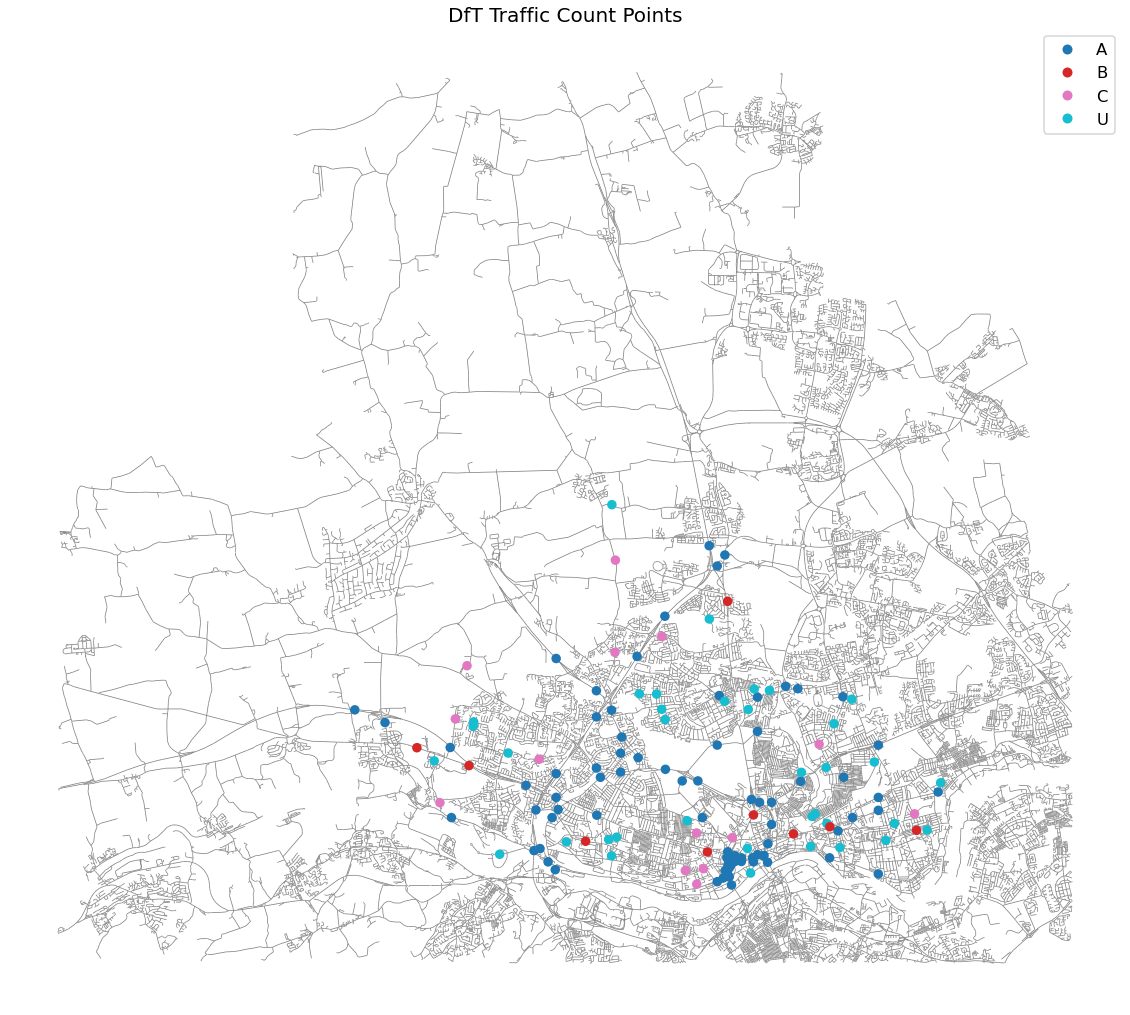

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, color="gray", linewidth=0.75)
dft.plot(ax=ax, markersize=64, column=dft["road_name"].str[0], zorder=2, legend=True)
ax.axis("off")
ax.set_title("DfT Traffic Count Points", fontsize=20)

### Snap DFT points to nearest  lines (roads) in space syntax model

Following approach from:
- https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa


In [50]:
def match_dft_ss(
    dft: pd.DataFrame, ss: gpd.GeoDataFrame, offset: float = 10, tol: float = 50
) -> gpd.GeoDataFrame:
    """
    Find the line segments in the space syntax data ss that are closest to the
    traffic measurement points in dft.

    Inspired by https://medium.com/@brendan_ward/6113c94e59aa
    """
    ss.sindex  # Create spatial index (makes computation faster later)

    # all space syntax (ss) segments that intersect DfT measurement points
    # (within offset metres east/north of measurement point):
    bbox = dft.bounds + [-offset, -offset, offset, offset]
    hits = bbox.apply(lambda row: list(ss.sindex.intersection(row)), axis=1)

    # convert hits to flat list (row cotaining list of matches, to rows each
    # containing 1 match)
    hits = pd.DataFrame(
        {
            # index of point in dft
            "pt_idx": np.repeat(hits.index, hits.apply(len)),
            # index of line segment in ss
            "line_idx": np.concatenate(hits.values),
        }
    )

    # Join ss and dft based on matched indices
    hits = hits.join(ss.reset_index(drop=True), on="line_idx")
    hits = hits.join(dft.rename(columns={"geometry": "point"}), on="pt_idx")
    hits = gpd.GeoDataFrame(hits, geometry="geometry", crs=dft.crs)

    # calculate distances between points and matched line segments
    hits["snap_dist"] = hits.geometry.distance(gpd.GeoSeries(hits.point))
    # discard any hits with more than tolerance metres between dft point
    # and ss segment
    hits = hits.loc[hits.snap_dist <= tolerance]

    # Select closest dft point and ss segment match
    hits = hits.sort_values(by=["snap_dist"])
    closest = hits.groupby("pt_idx").first()

    return gpd.GeoDataFrame(closest, geometry="geometry")

In [58]:
dft_ss = match_dft_ss(dft, ss)
dft_ss.head()

line_idx      fid     id  SegID       AI_   AI__N       AI__TD  \
pt_idx                                                                   
0          68856  68911.0  68911  21842  0.076951  104786  1361710.000   
1          62746  62801.0  62801  19669  0.057254  104786  1830165.750   
2          37123  37162.0  37162  11465  0.067958  104786  1541902.125   
3          22756  22795.0  22795   6747  0.087669  104786  1195233.500   
4          78512  78579.0  78579  24941  0.074670  104786  1403301.750   

           AI__MD           AC_  AC__NACH  ...  hgvs_3_or_4_articulated_axle  \
pt_idx                                     ...                                 
0       12.995276  5.581171e+07  1.262898  ...                             0   
1       17.465914  2.433474e+06  1.019758  ...                             9   
2       14.714913  2.599145e+08  1.359850  ...                             3   
3       11.406532  2.708388e+09  1.552083  ...                           119   
4       13.392201  5.400781e+07  1.257893  ...                             7   

        hgvs_5_articulated_axle  hgvs_6_articulated_axle all_hgvs  \
pt_idx                                                              
0                             1                        2      104   
1                            20                       12      240   
2                             3                        9      113   
3                           906                      947     3733   
4                             5                        5      116   

        all_motor_vehicles                          point     resid  \
pt_idx                                                                
0                     8358  POINT (419900.000 565000.000)  0.217774   
1                    21292  POINT (427000.000 564670.000) -2.287008   
2                    14107  POINT (426000.000 568200.000)  0.237247   
3                    85837  POINT (422700.000 570000.000) -0.597977   
4                     6864  POINT (424600.000 563910.000)  0.385552   

                pred  abs_resid snap_dist  
pt_idx                                     
0       10391.555684   0.217774  7.913170  
1        2162.626062   2.287008  2.772480  
2       17884.217499   0.237247  5.297804  
3       47203.724735   0.597977  4.231625  
4       10092.998507   0.385552  2.717567  

[5 rows x 50 columns]

(563225.0, 572869.0)

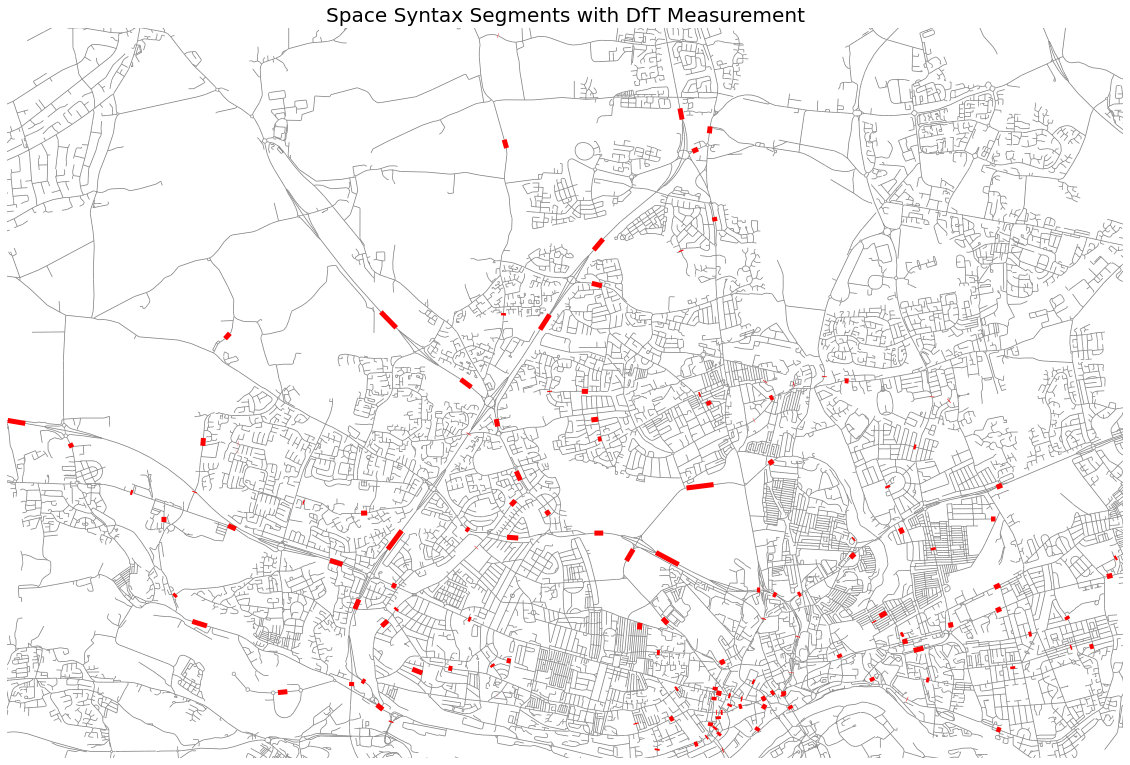

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, linewidth=0.75, color="gray")
dft_ss.plot(ax=ax, zorder=2, color="r", linewidth=5)
ax.axis("off")
ax.set_title("Space Syntax Segments with DfT Measurement", fontsize=20)
border = 100
ax.set_xlim([dft["easting"].min() - border, dft["easting"].max() + border])
ax.set_ylim([dft["northing"].min() - border, dft["northing"].max() + border])

Text(0, 0.5, 'log[all_motor_vehicles]')

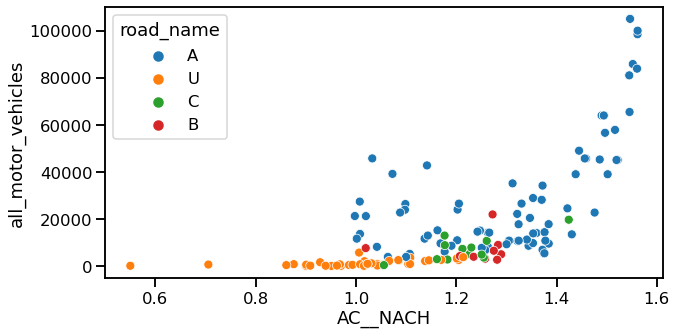

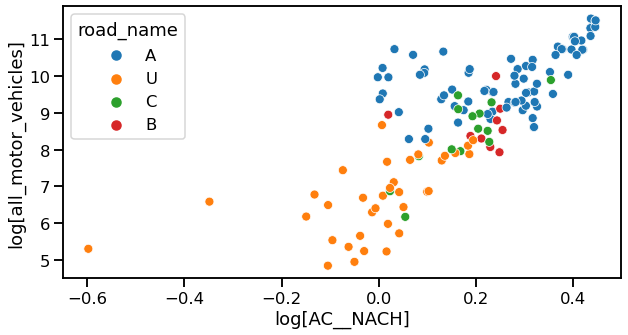

In [60]:
column = "AC__NACH"

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=dft_ss[column], y=dft_ss["all_motor_vehicles"], hue=dft_ss["road_name"].str[0]
)

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=np.log(dft_ss[column]),
    y=np.log(dft_ss["all_motor_vehicles"]),
    hue=dft_ss["road_name"].str[0],
)
plt.xlabel(f"log[{column}]")
plt.ylabel("log[all_motor_vehicles]")

In [61]:
print(np.corrcoef(dft_ss["AC__NACH"], dft_ss["all_motor_vehicles"]))
spearmanr(dft_ss["AC__NACH"], dft_ss["all_motor_vehicles"])

[[1.         0.67513373]
 [0.67513373 1.        ]]


SpearmanrResult(correlation=0.734746073292606, pvalue=1.632175584180499e-24)

7.535462013064182 [7.34026966]


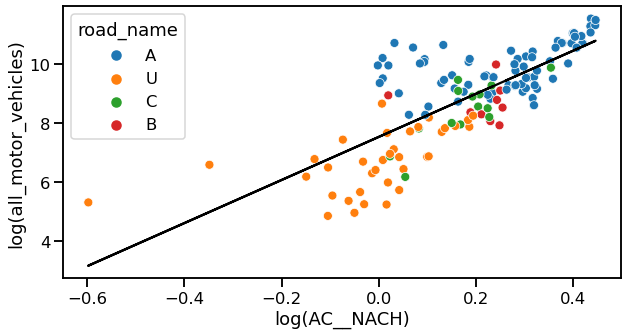

In [62]:
X = np.log(dft_ss["AC__NACH"]).values
y = np.log(dft_ss["all_motor_vehicles"])

mdl = LinearRegression()
mdl.fit(X.reshape(-1, 1), y)
print(mdl.intercept_, mdl.coef_)

y_pred = mdl.predict(X.reshape(-1, 1))
plt.figure(figsize=(10, 5))
plt.plot(X, y_pred, "k")
sns.scatterplot(x=X, y=y, hue=dft["road_name"].str[0])
plt.xlabel("log(AC__NACH)")
plt.ylabel("log(all_motor_vehicles)")

resid = y_pred - y
dft_ss["resid"] = resid
dft_ss["pred"] = np.exp(y_pred)


In [63]:
dft_ss["abs_resid"] = dft_ss["resid"].abs()

print("PRED (SYNTAX) > ACTUAL (DFT)")
display(dft_ss.sort_values(by="resid", ascending=False)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

print("PRED (SYNTAX) < ACTUAL (DFT)")
display(dft_ss.sort_values(by="resid", ascending=True)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

PRED (SYNTAX) > ACTUAL (DFT)


road_name road_type  all_motor_vehicles          pred     resid
pt_idx                                                                
509            U     Minor                 187   2103.021196  2.420022
433            U     Minor                 141   1295.220476  2.217676
400            U     Minor                 306   2546.385249  2.118845
122            U     Minor                 189   1499.762995  2.071315
123            U     Minor                 127    867.142324  1.921016
486            C     Minor                 479   2789.924931  1.762069
510            U     Minor                 212   1185.436069  1.721280
125            U     Minor                 396   2147.959118  1.690859
475            U     Minor                 286   1411.268926  1.596253
200            U     Minor                 625   2716.126498  1.469210
512        B1600     Minor                2774  11570.714877  1.428187
206            U     Minor                 965   3970.957536  1.414634
201            U     Minor                 949   3882.532049  1.408834
419            U     Minor                 254    928.786724  1.296545
1983        A186     Major                5500  19483.733601  1.264832

PRED (SYNTAX) < ACTUAL (DFT)


road_name road_type  all_motor_vehicles         pred     resid
pt_idx                                                               
1891        A695     Major               45770  2369.638055 -2.960892
9           A167     Major               27443  1980.678675 -2.628672
2212        A189     Major               39208  3138.429950 -2.525158
105         A695     Major               21314  1843.371850 -2.447768
1           A193     Major               21292  2162.626062 -2.287008
101         A191     Major               42793  4954.478453 -2.156083
126            U     Minor                 201    23.309282 -2.154453
17         A1056     Major               26404  3735.859713 -1.955538
34          A186     Major               13712  1986.629121 -1.931832
119        A1056     Major               22798  3480.900127 -1.879382
99            A1     Major               23978  3712.892889 -1.865325
2209        A695     Major               11709  1896.859032 -1.820158
518            U     Minor                 724   145.045458 -1.607744
120         A167     Major               26581  7379.310659 -1.281516
441        B6528     Minor                7696  2158.230076 -1.271412

(406369.1167578125, 434080.6132421875, 560276.3063867188, 584617.4136132812)

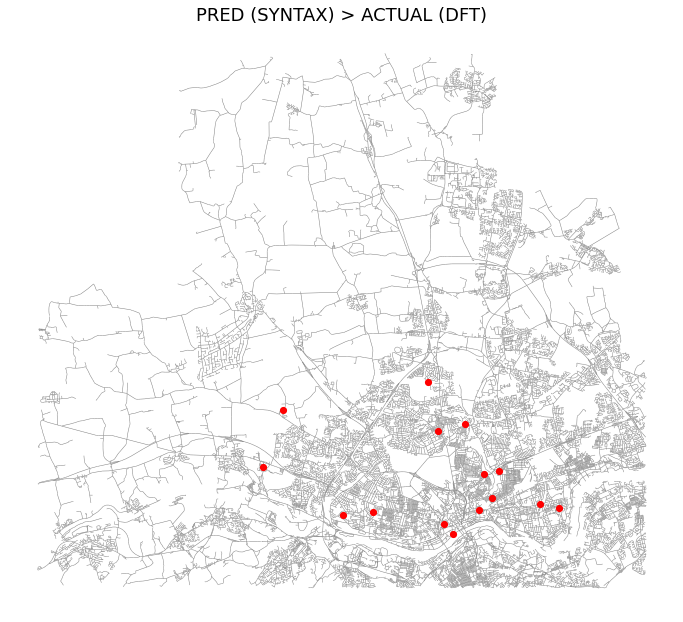

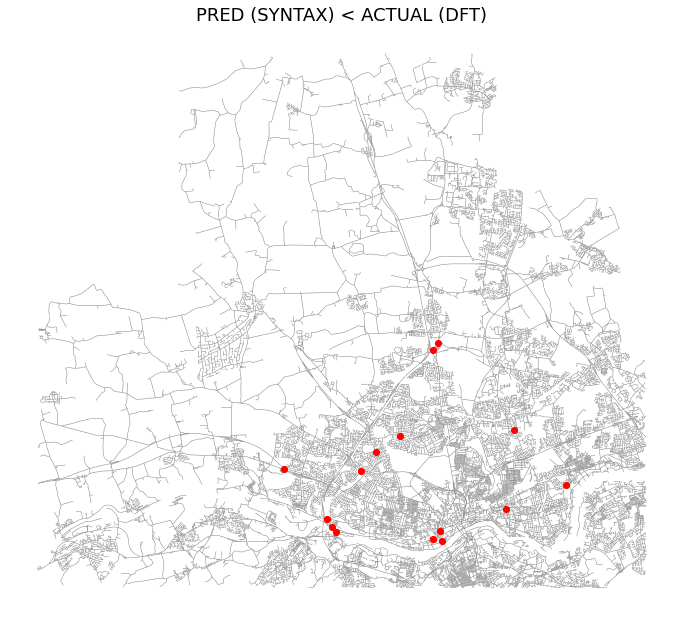

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, linewidth=0.5, color="gray")
dft_ss.sort_values(by="resid", ascending=False).head(15)["point"].plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) > ACTUAL (DFT)")
ax.axis("off")

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, linewidth=0.5, color="gray")
dft_ss.sort_values(by="resid", ascending=True).head(15)["point"].plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) < ACTUAL (DFT)")
ax.axis("off")

## Max Space Syntax in Output Area

In [69]:
oa = get_oa_shapes()
oa

geometry
oa11cd                                                      
E00042042  POLYGON ((421176.250 564469.753, 421177.231 56...
E00042043  POLYGON ((420510.000 564944.000, 420572.364 56...
E00042044  POLYGON ((420365.325 564561.637, 420438.986 56...
E00042045  POLYGON ((421543.715 563955.116, 421503.886 56...
E00042046  POLYGON ((422200.279 563353.233, 422078.508 56...
...                                                      ...
E00175601  POLYGON ((427400.000 567000.000, 427394.570 56...
E00175602  POLYGON ((421527.683 567236.668, 421490.250 56...
E00175603  POLYGON ((421600.722 567070.861, 421562.614 56...
E00175604  POLYGON ((421674.500 567305.188, 421628.847 56...
E00175605  POLYGON ((423981.359 571942.707, 423995.500 57...

[910 rows x 1 columns]

<AxesSubplot:>

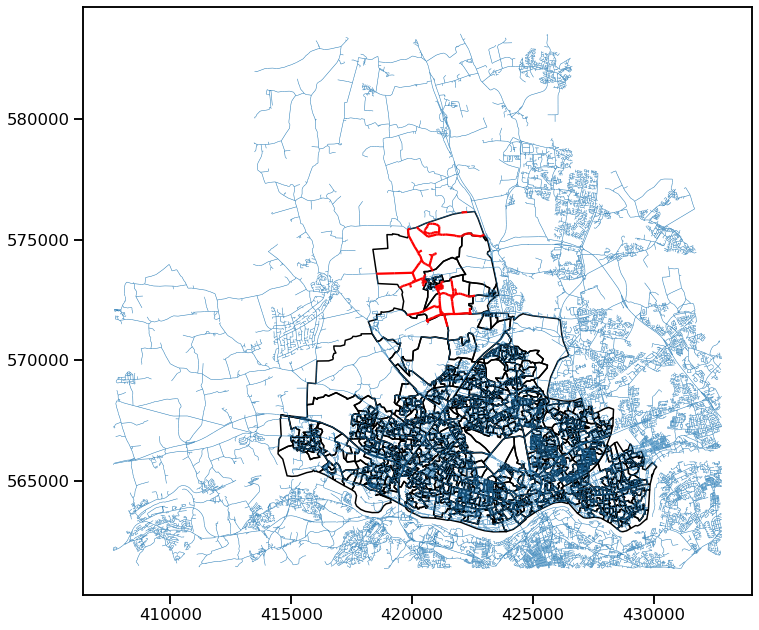

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
oa["select"] = False
oa.loc["E00042162", "select"] = True
# oa.plot(column="select", ax=ax)
oa.plot(color="None", ax=ax)
ss.plot(ax=ax, linewidth=0.5)
ss[
    ss.crosses(oa.loc["E00042162", "geometry"])
    | ss.within(oa.loc["E00042162", "geometry"])
].plot(color="r", ax=ax)

In [117]:
oa["AC__NACH_max"] = [
    ss[
        ss.crosses(oa.loc[oa_name, "geometry"]) | ss.within(oa.loc[oa_name, "geometry"])
    ]["AC__NACH"].max()
    for oa_name in oa.index
]
oa["AC__NACH_max"].fillna(1e-6, inplace=True)
oa["AC__NACH_max"]

In [144]:
oa["traffic_max"] = np.exp(mdl.predict(np.log(oa["AC__NACH_max"]).values.reshape(-1, 1)))
oa

geometry  select  \
oa11cd                                                                 
E00042042  POLYGON ((421176.250 564469.753, 421177.231 56...   False   
E00042043  POLYGON ((420510.000 564944.000, 420572.364 56...   False   
E00042044  POLYGON ((420365.325 564561.637, 420438.986 56...   False   
E00042045  POLYGON ((421543.715 563955.116, 421503.886 56...   False   
E00042046  POLYGON ((422200.279 563353.233, 422078.508 56...   False   
...                                                      ...     ...   
E00175601  POLYGON ((427400.000 567000.000, 427394.570 56...   False   
E00175602  POLYGON ((421527.683 567236.668, 421490.250 56...   False   
E00175603  POLYGON ((421600.722 567070.861, 421562.614 56...   False   
E00175604  POLYGON ((421674.500 567305.188, 421628.847 56...   False   
E00175605  POLYGON ((423981.359 571942.707, 423995.500 57...   False   

           AC__NACH_max   traffic_max  
oa11cd                                 
E00042042      1.380411  19966.779864  
E00042043      1.023544   2222.257380  
E00042044      1.137308   4816.939480  
E00042045      1.027928   2293.070941  
E00042046      1.271125  10898.847848  
...                 ...           ...  
E00175601      1.393584  21408.478282  
E00175602      1.187472   6612.473881  
E00175603      1.186111   6557.073877  
E00175604      1.108754   3996.797433  
E00175605      1.545537  45761.778910  

[910 rows x 4 columns]

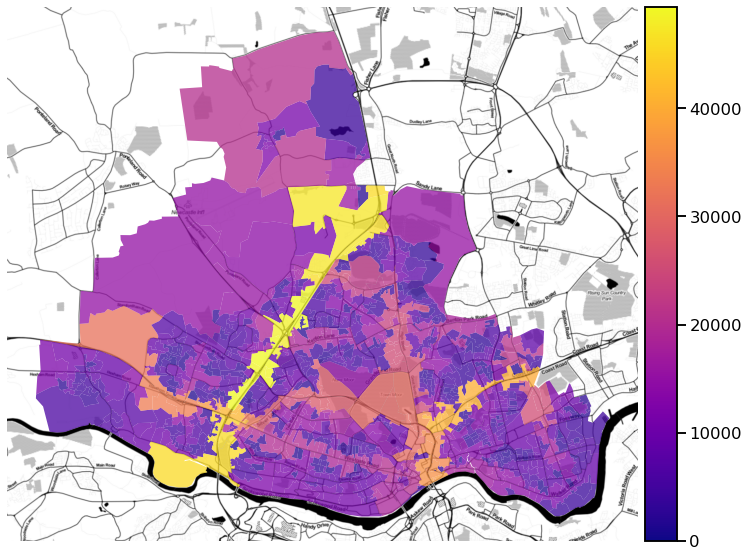

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
lad20cd = "E08000021"
plot_oa_weights(
    lad20cd,
    oa["traffic_max"],
    vmin=0,
    vmax=None,
    ax=ax
)


In [191]:
centroids = get_oa_centroids()
oa = oa.join(centroids)
theta = 500
cm =  coverage_matrix(oa["x"], oa["y"], theta=theta)

In [200]:
n_sensors = 20
r = greedy_opt(n_sensors, cm, oa["traffic_max"].values)

r = make_result_dict(
    lad20cd,
    n_sensors,
    theta,
    oa["x"].values,
    oa["y"].values,
    oa.index,
    r["sensors"],
    r["total_coverage"],
    r["point_coverage"],
    list(oa.index[r["placement_history"]]),
    r["coverage_history"],
    oa_weight=r["weights"],
    pop_age_groups={},
    population_weight=0,
    workplace_weight=0,
)

Placing sensor 1 out of 20 ... coverage = 0.04
Placing sensor 2 out of 20 ... coverage = 0.08
Placing sensor 3 out of 20 ... coverage = 0.11
Placing sensor 4 out of 20 ... coverage = 0.13
Placing sensor 5 out of 20 ... coverage = 0.16
Placing sensor 6 out of 20 ... coverage = 0.18
Placing sensor 7 out of 20 ... coverage = 0.20
Placing sensor 8 out of 20 ... coverage = 0.22
Placing sensor 9 out of 20 ... coverage = 0.24
Placing sensor 10 out of 20 ... coverage = 0.25
Placing sensor 11 out of 20 ... coverage = 0.27
Placing sensor 12 out of 20 ... coverage = 0.28
Placing sensor 13 out of 20 ... coverage = 0.29
Placing sensor 14 out of 20 ... coverage = 0.31
Placing sensor 15 out of 20 ... coverage = 0.32
Placing sensor 16 out of 20 ... coverage = 0.33
Placing sensor 17 out of 20 ... coverage = 0.34
Placing sensor 18 out of 20 ... coverage = 0.34
Placing sensor 19 out of 20 ... coverage = 0.35
Placing sensor 20 out of 20 ... coverage = 0.36


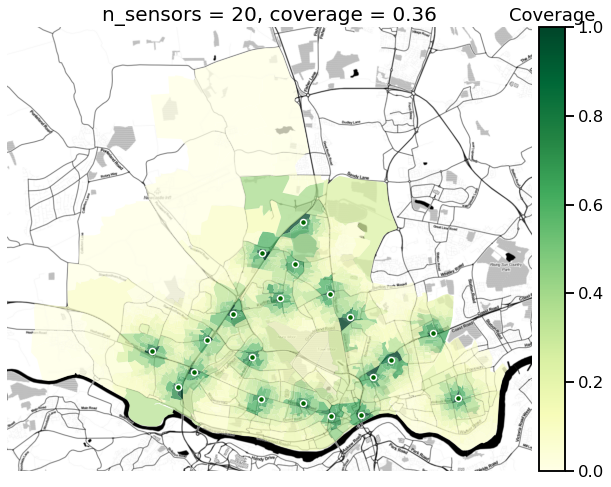

In [201]:
plot_optimisation_result(r)